__Project Overview:__

The aim of this project is to build and evaluate a mathematical model that can discriminate between two lung cancer subtypes. This model uses an unsupervised k-means clustering algorithm (Euclidean distance) and n-fold cross-validation of 58 Non-Small Cell Lung Cancer (NSCLC) tumors using k=2. 

The model is evaluated using metrics including accuracy, precision, recall, and f1 score. 

The overall objective of the model is to identify statistically significant gene-specific expression value differences between AD and SCC samples, and validate these biomarkers using previous literature to support its application and effectiveness in NSCLC biomarker discovery. 

The data, available in the SOFT formatted family file from GEO Accession [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245), contains 40 adenocarcinoma (AD) samples and 18 squamous cell carcinoma (SCC) samples. 

To run this supplementary notebook and the main _run_model.py_ analysis workflow, the above zipped data file should be located in the same directory as _run_model.py_. Additional run instructions and dependencies can be found in the README.md file.

__Packages:__

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../analysis'))

import process_data
import compute_metrics
import plot_metrics
import expr_analysis

__Parameters:__

The following parameters are set to the defaults values found in the _params.yaml_ file, but can be adjusted as needed.

In [2]:
#data:
raw_data_path = "../GSE10245_family.soft.gz" #should be located in same folder as 'run_model.py'
seed = 42

#clusters:
k = 2 #for kmeans
n_folds = 5 #for cross validation

#genes:
n_genes = 20
sort = 'descending' #ascending (least significant) or descending (most significant)
sort_by = 'Log p-value' #Gene, p-value, Log p-value, Bonferroni p-value, Significant (Bonferroni)
alpha = 0.05 #significance level

------------------------------------------------------------------------------------------------------------------------------

__1) Load in Data:__

The _process_data.py_ script reads in the dataset and utilizes GEOparse to extract gene expression values for each samples and its respective metadata. The data is reformatted further into a pandas dataframe for ease of use and visualization.

In [3]:
#organize sample and metadata data
gse_file, metadata = process_data.load_data(raw_data_path)

#assign gene expression data to samples
gene_expr_df, cancer_type_df = process_data.load_GSE(gse_file, metadata)
print("Total samples loaded:", len(gene_expr_df))

12-Feb-2025 14:26:51 INFO GEOparse - Parsing ../GSE10245_family.soft.gz: 
12-Feb-2025 14:26:51 DEBUG GEOparse - DATABASE: GeoMiame
12-Feb-2025 14:26:51 DEBUG GEOparse - SERIES: GSE10245
12-Feb-2025 14:26:51 DEBUG GEOparse - PLATFORM: GPL570
/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
12-Feb-2025 14:26:54 DEBUG GEOparse - SAMPLE: GSM258551
12-Feb-2025 14:26:54 DEBUG GEOparse - SAMPLE: GSM258552
12-Feb-2025 14:26:54 DEBUG GEOparse - SAMPLE: GSM258553
12-Feb-2025 14:26:54 DEBUG GEOparse - SAMPLE: GSM258554
12-Feb-2025 14:26:54 DEBUG GEOparse - SAMPLE: GSM258555
12-Feb-2025 14:26:55 DEBUG GEOparse - SAMPLE: GSM258556
12-Feb-2025 14:26:55 DEBUG GEOparse - SAMPLE: GSM258557
12-Feb-2025 14:26:55 DEBUG GEOparse - SAMPLE: GSM258558
12-Feb-2025 14:26:55 DEBUG GEOparse - SAMPLE: GSM258559
12-Feb-2025

Total samples loaded: 58


__View Data__:

Variables _gene_expr_df_ and _cancer_type_df_ are shown below, containing sampled IDs with gene expression values, and sample IDs paired with cancer type classification labels, respectively.

'AC' represents adenocarcinoma, and 'SCC' represent squamous cell carcinoma.

In [4]:
gene_expr_df #displays sample IDs and gene expression values for each gene (columns)

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
GSM258551,9.129905,8.034022,3.564520,4.746490,2.320698,5.519153,3.339182,2.775395,8.303437,2.981327,...,10.297589,8.857847,9.369037,9.435077,10.936404,10.730983,13.599488,13.031726,15.028729,14.586347
GSM258552,9.843349,7.973332,4.994852,5.197306,2.248520,5.081258,2.934516,2.617097,9.145519,4.619668,...,8.217455,7.865127,8.116953,8.306683,9.986505,9.719266,12.847711,12.250033,14.440756,14.072366
GSM258553,9.730661,8.834045,5.066018,5.234618,2.259504,4.657257,3.007192,2.634559,9.159054,2.746464,...,8.713199,6.996104,7.803869,8.029131,9.468096,9.101115,12.384142,11.798363,14.439887,14.011392
GSM258554,9.032165,7.723965,4.958580,6.078180,2.262787,4.535683,3.167112,3.127495,7.770354,6.212399,...,8.805233,8.221659,8.434090,8.609512,10.064087,9.763076,12.969199,12.307684,14.557363,14.162145
GSM258555,10.281793,9.040800,4.951835,5.205632,2.207531,3.731919,2.711790,2.707079,6.380928,4.528499,...,8.285092,8.042156,8.174685,8.620098,10.005558,9.651785,12.924465,12.243207,14.612223,14.122751
GSM258556,9.154551,8.792375,6.428274,5.009848,2.322618,4.964672,2.958602,2.598406,8.149710,4.008140,...,8.903710,8.088932,8.438776,8.687646,10.212622,9.716659,12.996885,12.369919,14.593751,14.202961
GSM258557,8.063788,8.093354,7.364676,5.533000,2.656929,5.794959,2.984828,2.634927,9.420926,4.039786,...,8.431760,8.395615,8.895953,9.058438,10.523917,10.224866,13.180944,12.688711,14.697993,14.339175
GSM258558,8.881805,7.575620,4.659326,5.362637,2.255955,5.416322,3.075674,2.637682,9.460713,2.797617,...,8.941418,8.205632,8.598923,8.832244,10.313588,9.968033,13.074864,12.541047,14.626500,14.292254
GSM258559,9.039005,8.438594,6.643723,5.210988,2.266399,5.627705,2.975612,2.663941,7.842213,2.748887,...,8.518448,8.189411,8.400951,8.484782,9.954478,9.698518,12.782987,12.103870,14.546733,14.058803
GSM258560,10.643545,9.142260,5.368356,5.195820,2.246563,4.174514,2.968054,2.609029,7.356981,2.722873,...,8.951526,8.004727,8.110386,8.529225,9.872159,9.457238,12.767953,12.280146,14.523177,14.159513


In [5]:
cancer_type_df #displays sample IDs with cancer type labels (AC or SCC)

,sample,Label,Type
0,GSM258551,AC,0
1,GSM258552,AC,0
2,GSM258553,SCC,1
3,GSM258554,AC,0
4,GSM258555,SCC,1
5,GSM258556,SCC,1
6,GSM258557,SCC,1
7,GSM258558,AC,0
8,GSM258559,AC,0
9,GSM258560,AC,0


------------------------------------------------------------------------------------------------------------------------------

__2) Cross-Validation and Clustering:__

The script _compute_metrics.py_ implements n-fold cross validation and subsequently k-means clustering via scikit-learn to predict cancer type labels on specific samples based on the provided subset of training data. Predictions are made using the gene expression values provided in the _gene_expr_df_ dataframe.

To assess the performance of the kmeans clustering model, metrics including accuracy, precision, recall, and f1 score are outputted for each individual training data fold, as well as the average across all folds. These values are displayed below and plotted using the _plot_metrics.py_ script.

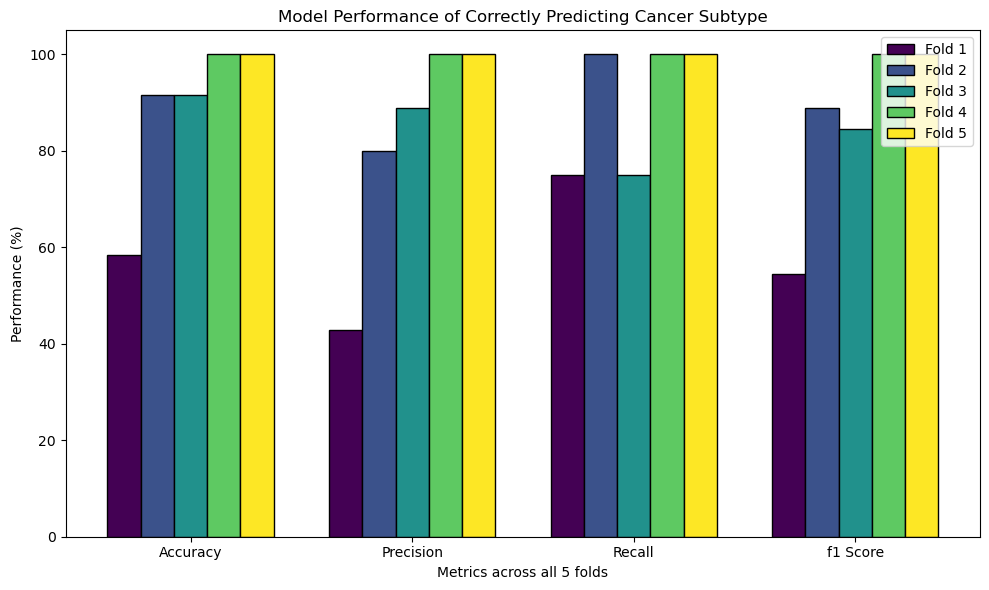

Metric avgs across 5 folds:
Accuracy: 0.88
Precision: 0.82
Recall: 0.9
f1 score: 0.86


In [7]:
#load k (number of clusters) and perform clustering on sample subsets selected using cross-validation
acc_list, prec_list, recall_list, f1_list = compute_metrics.cross_validate(gene_expr_df, cancer_type_df, k, n_folds, seed)

#plot metrics for each fold and average
avgs = plot_metrics.metrics_plot(acc_list, prec_list, recall_list, f1_list, n_folds)

print(f'Metric avgs across {n_folds} folds:')
print("Accuracy:", round(avgs[0], 2)) #overall correctness of predicitions
print("Precision:", round(avgs[1], 2)) #
print("Recall:", round(avgs[2], 2))
print("f1 score:", round(avgs[3], 2))

__Metric Performance Review__

From the above metric averages, an accuracy of 88% suggests that the Kmeans algorithm is correctly classifying the data most of the time. However, this metric alone can be misleading, especially considering the dataset imbalance (40 AC, 18 SCC). Both precision and recall help provide a better holistic image of how the model is performing. 

A precision sccore of 82% emphasizes the model's ability to predict a particular class correctly. In a medical context, this is especially valuable in order to avoid false positives.

A recall of 90% highlights that the model is correctly identifying most of the true positives, which is a critical component to minimize false negatives, or the event of missing cancer cases.

An f1 score of 86% reflects the balance between precision and recall, taking both false positives and false negatives into account. 

While the above metrics emphasize the effectiveness of the model to distinguish between AC and SCC cancer types, Kmeans clustering may not be best suited for this classification task due to its nature as an unsupervised model. In the future, supervised learning algorithms such as SVMs, neural networks, or random forests would be better suited for classification/labelling tasks.

------------------------------------------------------------------------------------------------------------------------------

__3) Gene Expression Analysis:__

The script _expr_analysis.py_ implements a supplementary gene expression analysis that enables the identification of genes that are statistically significant and contributing the most towards determining how a sample is clasified as either AC or SCC cancer.

Below, the top n genes that are simply expressed at a different level across all AC and SCC samples are shown.

In [8]:
#calculate mean gene expression differences between cancer types
mean_expr_all_df, AC_expr_df, SCC_expr_df = expr_analysis.expr_dif(gene_expr_df, cancer_type_df, sort)

if sort == 'ascending':
    print(f'Mean gene expression differences between AC and SCC cancer types (Bottom {n_genes} genes):')
elif sort == 'descending':
    print(f'Mean gene expression differences between AC and SCC cancer types (Top {n_genes} genes):')
mean_expr_all_df.head(n_genes)

Mean gene expression differences between AC and SCC cancer types (Top 20 genes):


,Gene,Mean Expression (AC),Mean Expression (SCC),Mean Expression Diff (abs)
11268,201820_at,3.000492,10.939535,7.939043
15611,206165_s_at,2.212801,9.058937,6.846136
41336,232082_x_at,2.749417,9.557599,6.808183
23096,213796_at,2.911232,9.560105,6.648873
44324,235075_at,2.883129,9.520257,6.637128
19269,209863_s_at,4.133841,10.527750,6.393910
26813,217528_at,3.341643,9.645309,6.303666
15479,206032_at,3.002822,9.140773,6.137951
15480,206033_s_at,2.626381,8.728752,6.102371
31076,221796_at,3.298267,9.387769,6.089501


Looking at the dataframe above, the largest disparities are primarily seen in genes that are more highly expressed in Squamous Cell Carcinoma opposed to Adenocarcinoma. This dataframe can help us identify potential biomarkers/genes that are associated in these specific diseases and their onset or regulation.

For example, the gene KRT5 (201820_at) has been specifically shown in [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8205719/) to serve as a potential biomarker for differentiating Squamous Cell Carcinoma from Adenocarcinoma. This aligns with the ordering of our dataframe and the expression difference between SCC and AD being the highest in KRT5 (201820_at).
 
While looking at the raw, absolute difference in expression in specific genes across cancer types can be informative, it does not provide any information on the statistical significance in these values. 

Continuing to use the _expr_analysis.py_ script below, the significance of the expression values found above can be determined by performing multiple t-tests between each gene of each sample. With an alpha of 0.05 (95% confidence) and using a Bonferroni correction to correct for multiple hypothesis testing, the signfiicance of gene expression differences are displayed below.

In [9]:
#determine significance of gene expression differences between cancer types
print('Calculating gene expression difference significance...')
sig_test_df = expr_analysis.calc_pval(AC_expr_df, SCC_expr_df, alpha, sort, sort_by)

if sort == 'ascending':
    print(f'Statistically significant genes (Sorted by {sort_by}; Bottom {n_genes} genes):')
elif sort == 'descending':
    print(f'Statistically significant genes (Sorted by {sort_by}; Top {n_genes} genes):') 
sig_test_df.head(n_genes)

Calculating gene expression difference significance...
Statistically significant genes (Sorted by Log p-value; Top 20 genes):


,Gene,p-value,Log p-value,Bonferroni p-value,Significant (Bonferroni)
38284,229030_at,1.581181e-14,13.801019,8.645105e-10,True
38626,229372_at,8.442795e-14,13.073514,4.616098e-09,True
38060,228806_at,1.228964e-12,11.910461,6.719361e-08,True
37833,228579_at,5.167087e-12,11.286754,2.825105e-07,True
2690,1555950_a_at,2.271999e-11,10.643592,1.242215e-06,True
11374,201926_s_at,2.811092e-11,10.551125,1.536964e-06,True
11266,201818_at,3.289819e-11,10.482828,1.798709e-06,True
11667,202219_at,4.764267e-11,10.322004,2.604863e-06,True
15087,205640_at,4.784050e-11,10.320204,2.615679e-06,True
44494,235245_at,6.918803e-11,10.159969,3.782855e-06,True


The dataframe above orders the statistically significant gene expression differences (at 95% confidence level) in Adenocarcinoma vs Squamous Cell Carcinoma in each sample. In total, there were 727 statistically significant gene expression differences.

The most statistically significant expression difference is found in CAPN8 (229030_at), which has been identified previously in [literature](https://pmc.ncbi.nlm.nih.gov/articles/PMC5641087/) specifically to differentiate squamous lung cancer from adenocarcinoma lung cancer. Other genes, such as RORC (228806_at) and GPR39 (229105_at) are included above and have both been shown to be upregulated in AC cancers. 

------------------------------------------------------------------------------------------------------------------------------

__3) Gene Search:__

Using the Gene IDs defined by GEO, the expression differences between cancer types and their significance can be searched using the code below, which is further defined in the _run_model.py_ script. This can be especially helpful for finding information such as up/downregulation trends in specific cancer types for relevant biomarkers, such as the previously emphasized genes CAPN8 (229030_at), RORC (228806_at), and GPR39 (229105_at).

In [10]:
#search specific gene (ex: 229030_at)
while True:
    gene_name = input('Enter Gene ID to search (or type "exit" to quit):')

    if gene_name.lower() == 'exit':
        break

    #search values for gene
    gene_searched_expr = mean_expr_all_df.loc[mean_expr_all_df['Gene'] == gene_name]
    gene_searched_pval = sig_test_df.loc[sig_test_df['Gene'] == gene_name]

    #check if gene/input exists
    if not gene_searched_expr.empty:
        print(gene_searched_expr)
        print(gene_searched_pval)
    else:
        print(f"Gene {gene_name} not found in dataset")
    print('')

            Gene  Mean Expression (AC)  Mean Expression (SCC)  \
38060  228806_at              6.653517               3.255328   

       Mean Expression Diff (abs)  
38060                    3.398189  
            Gene       p-value  Log p-value  Bonferroni p-value  \
38060  228806_at  1.228964e-12    11.910461        6.719361e-08   

       Significant (Bonferroni)  
38060                      True  

            Gene  Mean Expression (AC)  Mean Expression (SCC)  \
38359  229105_at              7.012199               3.535398   

       Mean Expression Diff (abs)  
38359                      3.4768  
            Gene       p-value  Log p-value  Bonferroni p-value  \
38359  229105_at  1.550831e-10     9.809436            0.000008   

       Significant (Bonferroni)  
38359                      True  

            Gene  Mean Expression (AC)  Mean Expression (SCC)  \
15087  205640_at              7.382579               4.773382   

       Mean Expression Diff (abs)  
15087              

Overall, this gene expression analysis complements the NSCLC type identification abilities of the previously defined kmeans algorithm. The two methodologies when applied in conjunction enable us to draw conclusions regarding not only the ability to correctly identify lung cancer subtypes by gene expression values with high efficiency and metric performance, but also utilize the gene expression values themselves to identify potential biomarkers in Adenocarcinoma and Squamous Cell Carcinoma.

As mentioned earlier, future directions for this analysis/workflow could include integrating different supervised algorithms such as random forest or SVM, which would be better suited for classification/labelling tasks and likely produce better metric performance as well. 

Additional metrics such as ROC-AUC score could be beneficial to compare as well, however this would require the addition of control, non-cancer samples to compare the ability of the model to classify cancer from non-cancer types. 

For ease of use, it would also be beneficial to alter the gene search function to also accept the shorthand gene abbreviations that are commonly used in literature, such as CAPN8 or GPR39.